# Load Models & Modules

In [1]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
# !git clone https://github.com/DhrubaAdhikary/ERA_V2.git -q --quiet
# !mv ERA_V2/pytorch-era2-main/* .
# !rm -rf ERA_V2/pytorch-era2-main
# print("Loaded Modules and Models")

# Installing latest Albumentation library
# !pip install -U git+https://github.com/albu/albumentations -q --quiet
!pip install torch-lr-finder -q --quiet
!pip install grad-cam

# For inline matplotlib plotting
%matplotlib inline

In [2]:
!pip install -U albumentations

# Loading train and test data with transforms and loader functions

In [3]:
!pip install lightning-bolts

In [4]:
# from pl_bolts.datamodules import CIFAR10DataModule

In [6]:
import sys
sys.path.append("/home/ec2-user/dhruv_Spain_LLM_UI/pytorch_era2_main")
from utils import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

/home/ec2-user/anaconda3/envs/Dhruv_env/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/ec2-user/anaconda3/envs/Dhruv_env/lib/python3.12/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/ec2-user/anaconda3/envs/Dhruv_env/lib/python3.12/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/ec2-user/anaconda3/envs/Dhruv_env/

CUDA availability ? False
Files already downloaded and verified
Files already downloaded and verified


# Exploratory Data Analysis

## Summary Statistics

In [7]:
cifar10.data_summary_stats()

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


## Plotting sample images

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


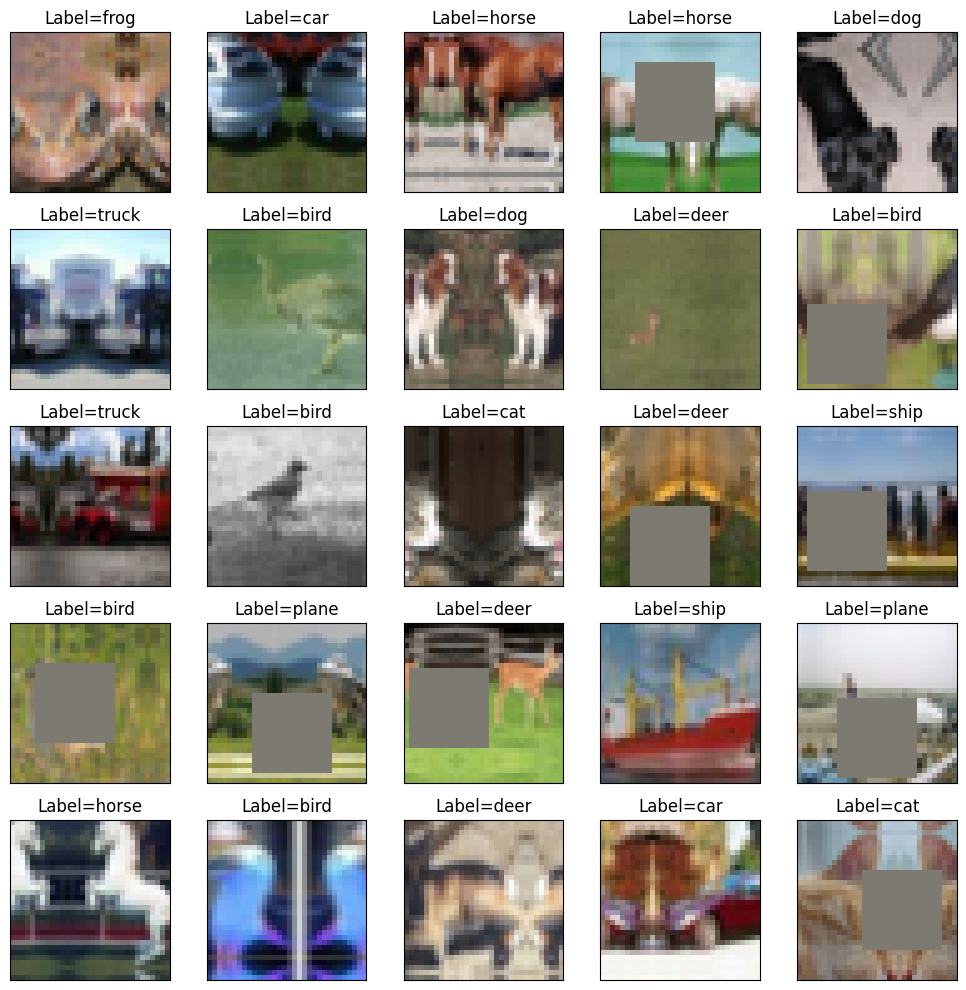

In [8]:
cifar10.sample_pictures(train_flag=True)

In [10]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Model

In [11]:
from models.resnet import *

# Loading Custom Model
net = ResNet18()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cpu


## Model Summary

In [12]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## LR Finder

In [13]:
steps_per_epoch = len(trainloader)
steps_per_epoch

98

In [14]:
# total_steps = 24 * steps_per_epoch
# total_steps

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [45:28<00:00, 13.64s/it]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.49E-01


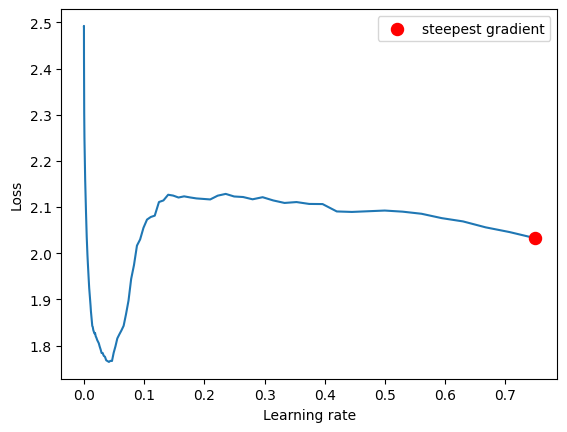

In [16]:
#https://github.com/davidtvs/pytorch-lr-finder

import copy
import torch
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import numpy as np

net_exp = copy.deepcopy(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_exp.parameters(), lr=1e-3, momentum=0.85)
lr_finder = LRFinder(net_exp, optimizer, criterion, device="cpu")
lr_finder.range_test(trainloader, start_lr=1e-5, end_lr=1, num_iter=200, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

## Define a Loss function and optimizer

In [19]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainloader),total_steps=2000,
                                                epochs=20,pct_start=0.2,
                                                anneal_strategy='linear')

## Training & Testing

In [20]:
# Load train and test model
from main import *

train = train()
test = test()

EPOCHS= 18

for epoch in range(EPOCHS):  # loop over the dataset multiple times
  #train.execute(net, device, batch, optimizer, criterion, epoch)
  train.execute(net, device, trainloader, optimizer, scheduler, criterion, epoch)
  test.execute(net, device, testloader, criterion)

print('Finished Training')

Epoch: 0,Loss=1.60 Batch_id=57 Accuracy=31.02:  59%|█████▉    | 58/98 [12:49<08:36, 12.90s/it]

## Display an image from the test set

Files already downloaded and verified


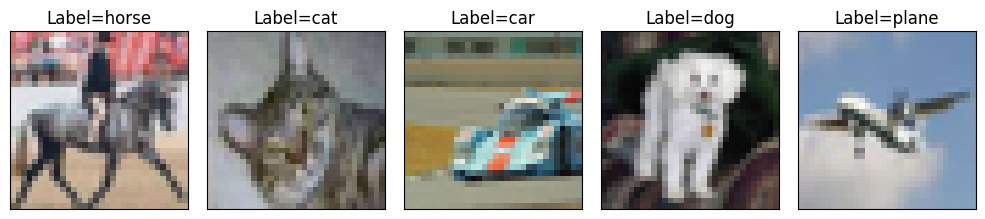

In [ ]:
images, labels = cifar10.sample_pictures(train_flag=False, return_flag = True)

## Prediction of sampe test set

In [ ]:
images,labels = images.to(device),labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  horse   cat   car   dog plane


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

idx = 4
model = net
target_layers = [model.layer4[-1]]
input_tensor = images[idx].unsqueeze(dim=0)# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(labels[idx])]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(unnormalize(images[idx].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7)

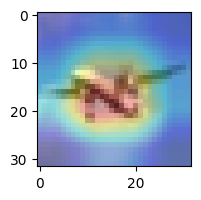

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(visualization)

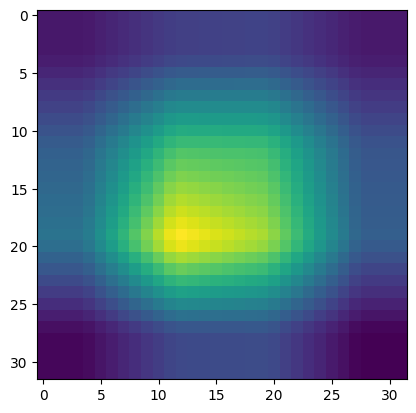

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(grayscale_cam)

In [ ]:
labels

tensor([7, 3, 1, 5, 0], device='cuda:0')

In [ ]:
list(classes)

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
images[0].shape

torch.Size([3, 32, 32])

## Evaluating Training Accuracy

In [ ]:
# from evaluate import *
# calAccuracy(net, trainloader, device)

## Evaluating Test Accuracy

In [ ]:
# calAccuracy(net, testloader, device)

## Evaluating test Accuracy over different classes

In [ ]:
# calClassAccuracy(net, testloader,classes, device)

## Misclassified Images

In [ ]:
# from utils import plot_misclassified_images
# plot_misclassified_images(net, testloader, classes, device)

In [ ]:
def plot_grad_cam_images(model, test_loader, classes, device):
    # set model to evaluation mode
    model.eval()
    target_layers = [model.layer4[-1]]

    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=model, target_layers=target_layers)

    misclassified_images = []
    actual_labels = []
    actual_targets = []
    predicted_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            for i in range(len(pred)):
                if pred[i] != target[i]:
                    actual_targets.append(target[i])
                    misclassified_images.append(data[i])
                    actual_labels.append(classes[target[i]])
                    predicted_labels.append(classes[pred[i]])

    # Plot the misclassified images
    fig = plt.figure(figsize=(12, 5))
    for i in range(10):
        sub = fig.add_subplot(2, 5, i+1)
        input_tensor = misclassified_images[i].unsqueeze(dim=0)
        targets = [ClassifierOutputTarget(actual_targets[i])]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(unnormalize(misclassified_images[i].cpu()), grayscale_cam, use_rgb=True, image_weight=0.7)

        # npimg = unnormalize(misclassified_images[i].cpu())
        # plt.imshow(npimg, cmap='gray', interpolation='none')

        # npimg = unnormalize(misclassified_images[i].cpu())
        plt.imshow(visualization)
        sub.set_title("Actual: {}, Pred: {}".format(actual_labels[i], predicted_labels[i]),color='red')
    plt.tight_layout()
    plt.show()

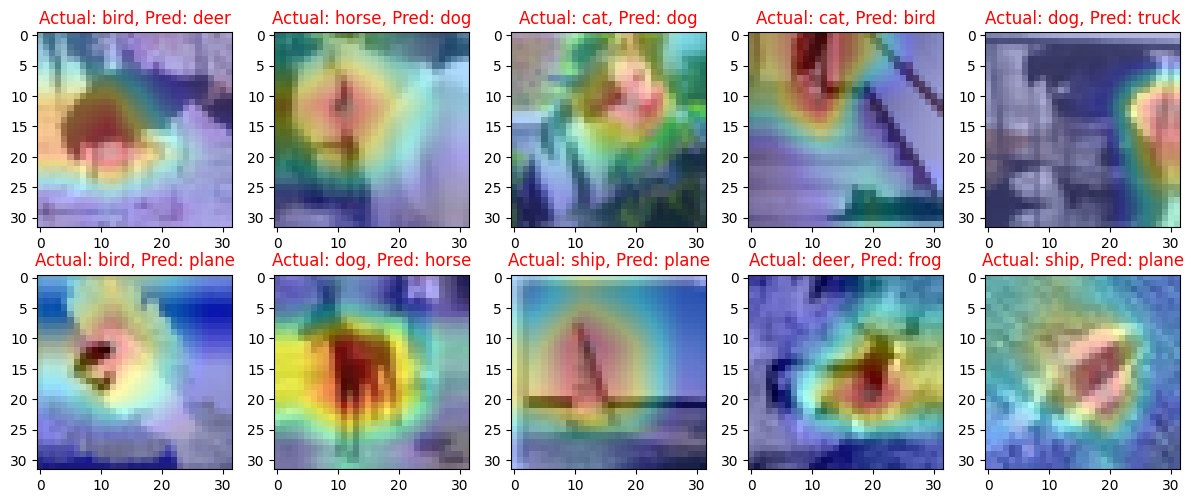

In [ ]:
plot_grad_cam_images(net, testloader, classes, device)